# Speech Recognition with Neural Networks: Utterance to Phoneme Mapping


In this assignment, you'll build a sequence-to-sequence model that maps speech utterances to phoneme sequences. You'll implement a recurrent neural network architecture that processes speech feature vectors (MFCCs) and outputs corresponding phoneme sequences.

## Key Components

- **Data Processing**: Work with Mel-Frequency Cepstral Coefficients (MFCCs) and handle variable-length sequences through padding and packing
- **Neural Network Architecture**: Implement a model using basic CNNs for feature extraction, BiLSTMs for sequential modeling, and optional pyramidal BiLSTMs for downsampling
- **CTC Loss**: Train your model using Connectionist Temporal Classification to handle sequence alignment challenges
- **Decoding Strategies**: Explore both greedy search and beam search for phoneme sequence generation
- **Evaluation**: Use Levenshtein Distance to measure the accuracy of your predicted phoneme sequences
- **Submission**: Submit your results on kaggle for final evaluation.

This assignment will give you practical experience with sequence modeling techniques essential to speech recognition systems while exploring various architectural choices and optimization strategies.

# Installs

In [1]:
# Setup Proxy
!source /etc/profile.d/clash.sh && proxy_on && echo $http_proxy

[√] 已开启代理
http://127.0.0.1:7890


In [2]:
!pip install torchinfo --quiet
!pip install python-Levenshtein --quiet

## Imports

In [3]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda:1


/home/xly/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Google Drive

# Uncomment this if you want to use Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Kaggle API Setup

!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    f.write('{"username":"____________","key":"_________________________"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

### Download Data (Chill out it will take a while😀)

!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c hw-3-p-2-automatic-speech-recognition-asr-11-785 # Download Data
!unzip -q hw-3-p-2-automatic-speech-recognition-asr-11-785.zip    # Unzip the dataset...

# Config

In [4]:
%%writefile config.yaml

# Subset of dataset to use (1.0 == 100% of data)
subset: 1.0
learning_rate: 0.001
epochs: 100
train_beam_width: 3
test_beam_width: 10
mfcc_features: 28 # DO NOT MODIFY

time_maskings: 10
freq_maskings: 5

# Set embedding size (the dimensionality of the LSTM hidden state)
embed_size: 320 # {64,128,256} Try out higher embed_size if you have powerfull GPU(RAM) other than T4

batch_size: 128 # Increase if your device can handle it

encoder dropout: 0.2
lstm dropout: 0.2
decoder dropout: 0.2
wandb: True # Set to True if you want to use WanDB

Name: "Lingyun Xu" # Write your name here

Overwriting config.yaml


In [5]:
import yaml
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [6]:
config

{'subset': 1.0,
 'learning_rate': 0.001,
 'epochs': 100,
 'train_beam_width': 3,
 'test_beam_width': 10,
 'mfcc_features': 28,
 'time_maskings': 10,
 'freq_maskings': 5,
 'embed_size': 320,
 'batch_size': 128,
 'encoder dropout': 0.2,
 'lstm dropout': 0.2,
 'decoder dropout': 0.2,
 'wandb': True,
 'Name': 'Lingyun Xu'}

In [7]:
BATCH_SIZE = config["batch_size"] # Define batch size from config
root = "/home/xly/11785/hw3p2/data" # Specify the directory to your root based on your environment

# Setup Vocabulary (DO NOT MODIFY)

In [8]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE

CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" :
     "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}


CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2] #To be used for mapping original transcripts to integer indices
LABELS = ARPAbet[:-2] #To be used for mapping predictions to strings
MAP = {k: i for i, k in enumerate(PHONEMES)} # NOTE: map phonemes to integers

OUT_SIZE = len(PHONEMES) # Number of output classes
print("Number of Phonemes:", OUT_SIZE)

# Indexes of BLANK and SIL phonemes
BLANK_IDX=CMUdict.index('')
SIL_IDX=CMUdict.index('[SIL]')

print("Index of Blank:", BLANK_IDX)
print("Index of [SIL]:", SIL_IDX)

Number of Phonemes: 41
Index of Blank: 0
Index of [SIL]: 1


### Sample data inspection & sanity check

In [9]:
test_mfcc = f"{root}/train-clean/mfcc/103-1240-0000.npy"
test_transcript = f"{root}/train-clean/transcript/103-1240-0000.npy"

mfcc = np.load(test_mfcc)
transcript = np.load(test_transcript)[1:-1] #Removed [SOS] and [EOS]

print("MFCC Shape:", mfcc.shape)
print("\nMFCC:\n", mfcc)
print("\nTranscript shape:", transcript.shape)

print("\nOriginal Transcript:\n", transcript)

# map the loaded transcript (from phonemes representation) to corresponding labels representation
mapped_transcript = [CMUdict_ARPAbet[k] for k in transcript]
print("\nTranscript mapped from PHONEMES representation to LABELS representation:\n", mapped_transcript)

# Mapping list of PHONEMES to list of Integer indexes
map = {k: i for i, k in enumerate(PHONEMES)}
print("\nMapping list of PHONEMES to list of Integer indexes:\n", map)



MFCC Shape: (1404, 28)

MFCC:
 [[ 1.10582151e+01  1.28330450e+01  2.10689220e+01 ... -8.75406042e-02
   7.30623007e-02  9.48924713e+01]
 [ 1.16850815e+01  1.38329487e+01  2.19087906e+01 ... -1.39180899e-01
  -6.15991093e-02  9.55670319e+01]
 [ 1.11048431e+01  1.67276516e+01  2.28863831e+01 ... -4.03698802e-01
   8.09250996e-02  9.54314651e+01]
 ...
 [ 2.62413955e+00 -1.26996317e+01  2.79472313e+01 ... -1.49060452e+00
  -2.67574161e-01  1.16191261e+02]
 [ 3.05713993e-02 -1.20763254e+01  2.60116520e+01 ... -8.54688883e-01
  -1.20284989e-01  1.17127373e+02]
 [-1.33604801e+00 -1.17101593e+01  2.44703121e+01 ... -9.30283189e-01
  -8.16672146e-02  1.18280014e+02]]

Transcript shape: (145,)

Original Transcript:
 ['[SIL]' 'CH' 'AE' 'P' 'T' 'ER' 'W' 'AH' 'N' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z'
 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D' 'IH' 'Z' 'S' 'ER' 'P' 'R' 'AY' 'Z'
 'D' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z' 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D'
 '[SIL]' 'L' 'AY' 'V' 'D' '[SIL]' 'JH' 'AH' 'S' 'T' 'W' 'EH' 'R' '

# Dataset and Dataloader

### Train Data

In [10]:
import torchaudio
class AudioDataset(torch.utils.data.Dataset):

    # For this homework, we give you full flexibility to design your data set class.
    # Hint: The data from HW1 is very similar to this HW

    def __init__(self, type='train'):
        '''
        Initializes the dataset.
        '''
        assert type in ['train', 'dev']
        self.PHONEMES = PHONEMES
        self.subset = config['subset']
        self.type=type

        # Define directories for MFCC and transcript files
        self.mfcc_dir = os.path.join(root, f'{type}-clean/mfcc')
        self.transcript_dir = os.path.join(root, f'{type}-clean/transcript')

        # Get sorted lists of files
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))
        self.transcript_files = sorted(os.listdir(self.transcript_dir))

        # Compute size of data subset
        subset_size = int(self.subset * len(self.mfcc_files))
        self.mfcc_files = self.mfcc_files[:subset_size]
        self.transcript_files = self.transcript_files[:subset_size]

        assert(len(self.mfcc_files) == len(self.transcript_files))
        self.length = len(self.mfcc_files)

        # Pre-load and process all data
        self.mfccs = []
        self.transcripts = []
        
        for mfcc_file, transcript_file in zip(self.mfcc_files, self.transcript_files):
            # Load MFCC and transcript
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_file))
            transcript = np.load(os.path.join(self.transcript_dir, transcript_file))
            
            # Remove SOS and EOS tokens from transcript
            transcript = transcript[1:-1]
            
            # Convert to tensors
            mfcc = torch.FloatTensor(mfcc)
            # TODO: Tensor can't contain strings or non-numerical values
        
            # transcript = [CMUdict_ARPAbet[p] for p in transcript]
            transcript = torch.tensor([MAP[p] for p in transcript])
            
            # Store processed data
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        return self.mfccs[ind], self.transcripts[ind]

    def collate_fn(self, batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # Split batch into features and labels
        batch_mfcc = [item[0] for item in batch] 
        batch_transcript = [item[1] for item in batch]

        # Get original lengths
        lengths_mfcc = [x.shape[0] for x in batch_mfcc]
        lengths_transcript = [x.shape[0] for x in batch_transcript]

        # Pad sequences
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
        batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)

        # Optional: Apply SpecAugment
        if self.type == "train":
            # Permute to (batch, freq, time) for time/freq masking
            batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)
            
            # Apply time and frequency masking
            transform = torchaudio.transforms.TimeMasking(time_mask_param=config['time_maskings'])
            batch_mfcc_pad = transform(batch_mfcc_pad)
            
            transform = torchaudio.transforms.FrequencyMasking(freq_mask_param=config['freq_maskings'])
            batch_mfcc_pad = transform(batch_mfcc_pad)
            
            # Permute back to (batch, time, freq)
            batch_mfcc_pad = batch_mfcc_pad.permute(0, 2, 1)

        return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)


### Test Data

In [11]:
# TODO
# Food for thought -> Do you need to apply transformations in this test dataset class?
class AudioDatasetTest(torch.utils.data.Dataset):
    def __init__(self):
        """
        Initialize the test dataset
        Args:
            data_path: Path to test MFCC features
        """
        self.PHONEMES = PHONEMES

        # Define directories for MFCC and transcript files
        self.mfcc_dir = os.path.join(root, 'test-clean/mfcc')

        # Get sorted lists of files
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))

        self.length = len(self.mfcc_files)

        # Pre-load and process all data
        self.mfccs = []
        
        for mfcc_file in self.mfcc_files:
            # Load MFCC
            mfcc = np.load(os.path.join(self.mfcc_dir, mfcc_file))
            
            # Convert to tensors
            mfcc = torch.FloatTensor(mfcc)
            
            # Store processed data
            self.mfccs.append(mfcc)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, ind):
        return self.mfccs[ind]

    def collate_fn(self, batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'
        2.  We will additionally need to pad both features and labels,
            look at pytorch's docs for pad_sequence
        3.  NOTE: No data augmentation for test dataset
        4.  Return batch of features, labels, lenghts of features,
            and lengths of labels.
        '''
        # Split batch into features and labels
        batch_mfcc = [item for item in batch]

        # Get original lengths
        lengths_mfcc = [x.shape[0] for x in batch_mfcc]

        # Pad sequences
        batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)


In [12]:
# To free up ram
import gc
gc.collect()

0

### Create Datasets & Data loaders

In [13]:
# Create objects for the dataset classes
train_data = AudioDataset() # TODO: Fill in the required parameters
val_data = AudioDataset(type='dev') # TODO: You can either use the same class for train data with some modifications or make a new one :)

In [14]:
test_data = AudioDatasetTest() # TODO: Fill in the required parameters

In [15]:
# Do NOT forget to pass in the collate function as an argument while creating the dataloader
train_loader = DataLoader(train_data, batch_size=config['batch_size'], shuffle=True, collate_fn=train_data.collate_fn)

val_loader = DataLoader(val_data, batch_size=config['batch_size'], shuffle=True, collate_fn=val_data.collate_fn)

test_loader = DataLoader(test_data, batch_size=config['batch_size'], shuffle=False, collate_fn=test_data.collate_fn)

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [16]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([128, 1669, 28]) torch.Size([128, 207]) torch.Size([128]) torch.Size([128])


# Visualize Data

Note: In the visualized graph, do not confuse padded regions of the MFCC sequences with time/freq augmentation masks. Remember all MFCCs were padded to the maximum sequence length

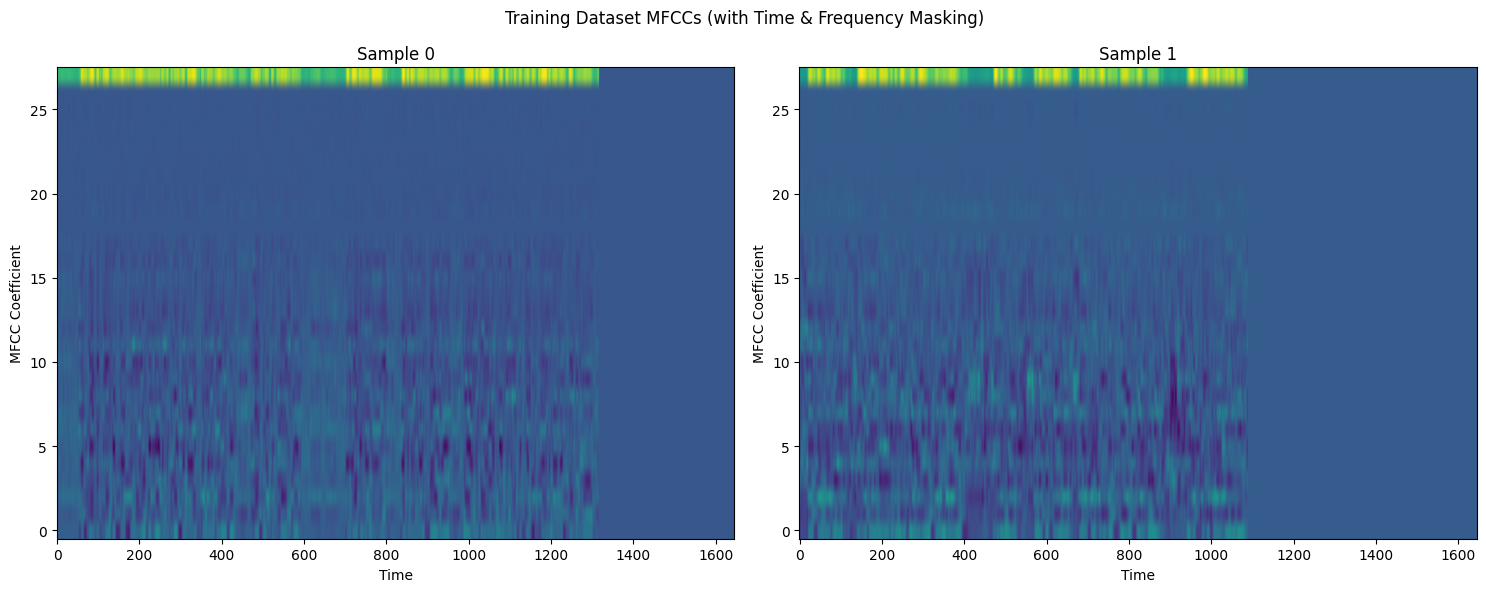

In [17]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn we defined in the dataset class returns a tuple, where the first element is the padded MFCC tensor.
    mfcc_batch = batch[0] if isinstance(batch, (tuple, list)) else batch

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15,6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Each MFCC tensor is of shape [time, frequency].
        # Transpose for visualization: time on x-axis, features on y-axis.
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize batches of data
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


# Network

## Basic network (Optional)

This is a basic block for understanding, you can skip this and move to pBLSTM one

torch.cuda.empty_cache()

class Network(nn.Module):

    def __init__(self):

        super(Network, self).__init__()

        # TODO: Adding some sort of embedding layer or feature extractor might help performance.
        # You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here?
        #                  -> What should be the size of input channels to the first layer?
        self.embedding = _________________________ #TODO

        # TODO : look up the documentation. You might need to pass some additional parameters.
        self.lstm = nn.LSTM(input_size = __________________, hidden_size = 256, num_layers = 1) #TODO

        self.classification = nn.Sequential(
            #TODO: Linear layer with in_features from the lstm module above and out_features = OUT_SIZE
        )


        self.logSoftmax =__________________ #TODO: Apply a log softmax here. Which dimension would apply it on ?

    def forward(self, x, lx):
        #TODO
        # The forward function takes 2 parameter inputs here. Why?
        # Refer to the handout for hints
        pass


## Initialize Basic Network
(If trying out the basic Network)

torch.cuda.empty_cache()

model = Network().to(device)
print(model)


## ASR Network
We define everything we need for the ASR model in separate classes, and put them all together in the end

#### Permute class

In [18]:
class Permute(torch.nn.Module):
    '''
    Used to transpose/permute the dimensions of an MFCC tensor.
    '''
    def forward(self, x):
        return x.transpose(1, 2) # NOTE: [batch, time, freq] -> [batch, freq, time]

#### Pyramidal Bi-LSTM (pBLSTM) class

In [19]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input? # NOTE: excluded the last time step or pad with 0s
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=input_size*2, hidden_size=hidden_size, 
                                 bidirectional=True, batch_first=True)

    def forward(self, x_packed):
        # TODO: Pad Packed Sequence
        # Unpack the packed sequence
        x, x_lens = torch.nn.utils.rnn.pad_packed_sequence(x_packed, batch_first=True)
        
        # Downsample and reshape
        # TODO: Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.

        x, x_lens = self.trunc_reshape(x, x_lens)
        
        # Pack the sequence again
        # TODO: Pack Padded Sequence
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, 
                                                         batch_first=True,
                                                         enforce_sorted=False)
            
        # Pass through BLSTM
        # TODO: Pass the sequence through bLSTM
        output, _ = self.blstm(x_packed)
        
        return output

    def trunc_reshape(self, x, x_lens):
        batch_size, timesteps, features = x.size()
        
        # Handle odd number of timesteps by truncating the last timestep
        if timesteps % 2 != 0:
            x = x[:, :-1, :]
            timesteps -= 1
            x_lens = torch.where(x_lens % 2 != 0, x_lens - 1, x_lens)
        
        # Reshape to reduce timesteps by factor of 2 and double features
        x = x.contiguous().view(batch_size, timesteps//2, features*2)
        
        # Reduce lengths by factor of 2
        x_lens = torch.div(x_lens, 2, rounding_mode='floor')
        
        return x, x_lens

#### Util for LSTM


In [20]:
class LSTMWrapper(torch.nn.Module):
    '''
    Used to get only output of lstm, not the hidden states.
    '''
    def __init__(self, lstm):
        super(LSTMWrapper, self).__init__()
        self.lstm = lstm

    def forward(self, x):
        output, _ = self.lstm(x)
        return output

#### Encoder class

In [21]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()


        # TODO: You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
        # Food for thought -> What type of Conv layers can be used here? # NOTE: Conv1d
        #                  -> What should be the size of input channels to the first layer? # NOTE: 
        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, input_size, kernel_size=3, padding=1),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.ReLU(),
            torch.nn.Conv1d(input_size, input_size, kernel_size=3, padding=1),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.ReLU(),
            torch.nn.Conv1d(input_size, input_size, kernel_size=3, padding=1),
            torch.nn.BatchNorm1d(input_size),
            torch.nn.ReLU()
        )

        # TODO:
        self.BLSTMs = LSTMWrapper(
            # TODO: Look up the documentation. You might need to pass some additional parameters.
            torch.nn.LSTM(input_size=input_size, \
                          hidden_size=encoder_hidden_size, \
                          num_layers=4, \
                          bidirectional=True,
                          batch_first=True
            ) #TODO
          )

        self.pBLSTMs = torch.nn.Sequential( # How many pBLSTMs are required?
            # TODO: Fill this up with pBLSTMs - What should the input_size be?
            # Hint: You are downsampling timesteps by a factor of 2, upsampling features by a factor of 2 and the LSTM is bidirectional)
            # Optional: Dropout/Locked Dropout after each pBLSTM (Not needed for early submission)
            # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
            # ...
            # ...
            pBLSTM(input_size=encoder_hidden_size*2, hidden_size=encoder_hidden_size),
            pBLSTM(input_size=encoder_hidden_size*2, hidden_size=encoder_hidden_size),
        )

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader

        # TODO: Call the embedding layer
        x = x.permute(0, 2, 1)  # (batch, time, features) -> (batch, channels, time)
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # (batch, channels, time) -> (batch, time, channels)
        # TODO: Pack Padded Sequence
        x_packed = torch.nn.utils.rnn.pack_padded_sequence(
            x, lengths=x_lens.cpu().to(torch.int64), batch_first=True, enforce_sorted=False
        )
        
        # TODO: Pass Sequence through the Bi-LSTM layer
        x_packed = self.BLSTMs(x_packed) # NOTE: the LSTMWrapper only returns the output, not the hidden states
        # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        x_packed = self.pBLSTMs(x_packed)
        # TODO: Pad Packed Sequence
        encoder_outputs, encoder_lens = torch.nn.utils.rnn.pad_packed_sequence(
            x_packed, batch_first=True
        )   
        # Remember the number of output(s) each function returns

        return encoder_outputs, encoder_lens

#### Decoder class

In [22]:
class Decoder(torch.nn.Module):

    def __init__(self, embed_size, output_size=41):
        super().__init__()

        self.mlp = torch.nn.Sequential(
            Permute(),
            torch.nn.BatchNorm1d(2 * embed_size),
            Permute(),
            
            torch.nn.Linear(2 * embed_size, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(128, output_size)
        )

        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, encoder_out): # NOTE: Take in the encoder logits
        # Pass through MLP 
        out = self.mlp(encoder_out)
        
        # Apply log softmax for classification
        out = self.softmax(out)
        
        return out

#### ASR Model Class

In [23]:
class ASRModel(torch.nn.Module):

    def __init__(self, input_size, embed_size=192, output_size=len(PHONEMES)):
        super().__init__()

        # Initialize encoder and decoder
        self.encoder = Encoder(input_size=input_size, 
                             encoder_hidden_size=embed_size)
        
        self.decoder = Decoder(embed_size=embed_size, 
                             output_size=output_size)

    def forward(self, x, lengths_x):
        encoder_out, encoder_lens = self.encoder(x, lengths_x)
        decoder_out = self.decoder(encoder_out)

        return decoder_out, encoder_lens

## Initialize ASR Network

In [24]:
model = ASRModel(
    input_size  = config['mfcc_features'],  #TODO,
    embed_size  = config['embed_size'], #TODO
    output_size = len(PHONEMES)
).to(device)

In [25]:
summary(model, input_data=[x.to(device), lx.to(device)])

Layer (type:depth-idx)                   Output Shape              Param #
ASRModel                                 [128, 417, 41]            --
├─Encoder: 1-1                           [128, 417, 640]           --
│    └─Sequential: 2-1                   [128, 28, 1669]           --
│    │    └─Conv1d: 3-1                  [128, 28, 1669]           2,380
│    │    └─BatchNorm1d: 3-2             [128, 28, 1669]           56
│    │    └─ReLU: 3-3                    [128, 28, 1669]           --
│    │    └─Conv1d: 3-4                  [128, 28, 1669]           2,380
│    │    └─BatchNorm1d: 3-5             [128, 28, 1669]           56
│    │    └─ReLU: 3-6                    [128, 28, 1669]           --
│    │    └─Conv1d: 3-7                  [128, 28, 1669]           2,380
│    │    └─BatchNorm1d: 3-8             [128, 28, 1669]           56
│    │    └─ReLU: 3-9                    [128, 28, 1669]           --
│    └─LSTMWrapper: 2-2                  [163767, 640]             --
│    │

# Training Config
Initialize Loss Criterion, Optimizer, CTC Beam Decoder, Scheduler, Scaler (Mixed-Precision), etc

In [26]:
# CTC Loss - uses log softmax internally so we don't need an extra log softmax layer
criterion = nn.CTCLoss(
    blank=BLANK_IDX,  # Index of blank token 
    reduction='mean', # Average loss over batch
    zero_infinity=True # Handle inf values that may occur with small batches
).to(device)

# AdamW optimizer with weight decay for regularization
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=0.01
)

# CTC Decoder for beam search decoding during training
decoder = cuda_ctc_decoder(
    tokens=LABELS,
    nbest=1,
    beam_size=config['train_beam_width']
)

# Cosine annealing scheduler with warm restarts
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Initial restart period
    T_mult=2, # Multiple for subsequent restart periods
    eta_min=1e-6 # Minimum learning rate
)

# Mixed Precision scaler for faster training
scaler = torch.cuda.amp.GradScaler()

### Decode Prediction

In [27]:
def decode_prediction(output, output_lens, decoder: cuda_ctc_decoder, PHONEME_MAP = LABELS):
    '''
    Map the decode results from cuda_ctc_decoder to phoneme labels using PHONEME_MAP
    '''
    # Look at docs for CUDA_CTC_DECODER for more info on how it was used here:
    # https://pytorch.org/audio/main/tutorials/asr_inference_with_cuda_ctc_decoder_tutorial.html
    output = output.contiguous()
    output_lens = output_lens.to(torch.int32).contiguous()
    beam_results = decoder(output, output_lens.to(torch.int32)) #lengths - list of lengths

    pred_strings                    = []

    for i in range(len(beam_results)):
        # Create the prediction from the output of the cuda_ctc_decoder. Don't forget to map it using PHONEMES_MAP.
        # NOTE: PHONEMES_MAP should be the phoneme LABELS instead, as defined above as LABELS
        # Get the top prediction for each sequence in the batch
        top_beam_results = beam_results[i][0].tokens

        # TODO: Map the sequence of indices to actual phoneme LABELS and join them into a string
        # Append to predited strings list after joining
        pred_string = ''.join([PHONEME_MAP[idx] for idx in top_beam_results])
        pred_strings.append(pred_string)

    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP= LABELS): # y - sequence of integers

    dist            = 0
    batch_size      = label.shape[0]

    pred_strings    = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        # TODO: Get predicted string and label string for each element in the batch

        # Get actual length of this sequence (without padding)
        actual_len = label_lens[i]

        label_phonemes = label[i,:actual_len].cpu().numpy()
        label_string = ''.join([PHONEME_MAP[idx] for idx in label_phonemes]) # TODO
        pred_string = pred_strings[i] # TODO: Predicted string from decode_prediction

        dist += Levenshtein.distance(pred_string, label_string)

    # Average the distance over the batch
    dist /= batch_size # Think about why we are doing this
    return dist

In [28]:
torch.cuda.empty_cache()
gc.collect()

0

## Test Implementation

In [29]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    lx, ly = lx.to(device), ly.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, LABELS))

    del x, y, lx, ly, h, lh, loss
    torch.cuda.empty_cache()

    break

torch.Size([128, 709, 41])
torch.Size([709, 128, 41]) torch.Size([128, 287])
tensor(7.1238, device='cuda:1', grad_fn=<MeanBackward0>)
71.2890625


## WandB

In [30]:
# Use wandb? Resume Training?
USE_WANDB = config['wandb']

RESUME_LOGGING = False # Set this to true if you are resuming training from a previous run

# Create your wandb run

run_name = '{}_0325'.format(config['Name'])

# If you are resuming an old run
if USE_WANDB:

    wandb.login(key="4dd2f46439865db4e3547d39c268ff46468b8ef4") #TODO

    if RESUME_LOGGING:
        run = wandb.init(
            id     = "", ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs
            project = "hw3p2-ablations", ### Project should be created in your wandb
            settings = wandb.Settings(_service_wait=300)
        )


    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw3p2-ablations", ### Project should be created in your wandb account
            config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/xly/.netrc


wandb: Currently logged in as: avidjoyce23 (avidjoyce23-peking-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Training Functions

In [31]:
# Train function
def train_model(model, train_loader, criterion, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.06f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close() # You need this to close the tqdm bar

    return total_loss / len(train_loader)


# Eval function
def validate_model(model, val_loader, decoder, phoneme_map= LABELS):

    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)
            h = torch.permute(h, (1, 0, 2))
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()
        vdist += calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, phoneme_map)

        batch_bar.set_postfix(loss="{:.04f}".format(float(total_loss / (i + 1))), dist="{:.04f}".format(float(vdist / (i + 1))))

        batch_bar.update()

        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    total_loss = total_loss/len(val_loader)
    val_dist = vdist/len(val_loader)
    return total_loss, val_dist


### Model Saving & Loading functions

In [32]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         f"{path}_{device}_dist={metric[1]}_{epoch}.pth"
    )

def load_model(path, model, optimizer= None, scheduler= None, metric='valid_dist'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Dist:", metric)

    return [model, optimizer, scheduler, epoch, metric]

## Training Loop

In [33]:
# Instantiate variables used in training loop
last_epoch_completed = 0
best_lev_dist = float("inf")

#### Uncomment this if resuming training from model checkpoint

In [34]:
# RESUME_TRAINING = True # Set this to true if you are resuming training from a mpdel checkpoint

# if RESUME_TRAINING:

#     checkpoint_path = ''
#     checkpoint = load_model(checkpoint_path, model, optimizer, scheduler, metric='valid_dist')

#     last_epoch_completed = checkpoint[3]
#     best_lev_dist = checkpoint[4]

In [35]:
# Set up checkpoint directories and WanDB logging watch
checkpoint_root = os.path.join(os.getcwd(), 'checkpoints')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_model_filename = 'best'
checkpoint_last_epoch_filename = 'last'
epoch_model_path = os.path.join(checkpoint_root, checkpoint_last_epoch_filename)
best_model_path = os.path.join(checkpoint_root, checkpoint_best_model_filename)

# WanDB log watch
if config['wandb']:
  wandb.watch(model, log="all")


In [36]:
# Clear RAM for storage before you start training
torch.cuda.empty_cache()
gc.collect()

20

#### Iterate over the number of epochs to train and evaluate your model


In [ ]:
for epoch in range(last_epoch_completed, config['epochs']):
    print("\nEpoch: {}/{}".format(epoch + 1, config['epochs']))

    # Get current learning rate
    curr_lr = optimizer.param_groups[0]['lr']

    # Train and validate
    train_loss = train_model(model, train_loader, criterion, optimizer)
    valid_loss, valid_dist = validate_model(model, val_loader, decoder, LABELS)

    # Update learning rate using scheduler
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}\t Val Loss {:.04f}".format(valid_dist, valid_loss))

    if config['wandb']:
        wandb.log({
            'train_loss': train_loss,
            'valid_dist': valid_dist,
            'valid_loss': valid_loss,
            'lr': curr_lr
    })

    # # Save last epoch model

    # save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)
    # if config['wandb']:
    #     wandb.save(epoch_model_path)
    # print("Saved epoch model")

    if valid_dist <= best_lev_dist and valid_dist < 5.3: # NOTE: Only save model that is good enough
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        if config['wandb']:
            wandb.save(best_model_path)
        print("Saved best val model")

# Finish Wandb run
if config['wandb']:
    run.finish()



Epoch: 1/100


	Train Loss 3.4222	 Learning Rate 0.0010000
	Val Dist 67.8600	 Val Loss 3.1657

Epoch: 2/100


	Train Loss 2.1115	 Learning Rate 0.0009756
	Val Dist 25.1978	 Val Loss 1.1163

Epoch: 3/100


	Train Loss 0.9344	 Learning Rate 0.0009046
	Val Dist 17.6227	 Val Loss 0.7943

Epoch: 4/100


	Train Loss 0.6991	 Learning Rate 0.0007941
	Val Dist 12.9802	 Val Loss 0.5881

Epoch: 5/100


Train:  48%|████▊     | 107/223 [01:02<01:07,  1.71it/s, loss=0.5462, lr=0.000655]

# Generate Predictions and Submit to Kaggle

In [ ]:
#TODO: Make predictions

# Follow the steps below:
# 1. Create a new object for CUDA_CTC_DECODER with larger number of beams (why larger?)
# 2. Get prediction string by decoding the results of the beam decoder
model = ASRModel(
    input_size  = config['mfcc_features'],  #TODO,
    embed_size  = config['embed_size'], #TODO
    output_size = len(PHONEMES)
).to(device)

path = "/home/xly/11785/hw3p2/checkpoints/mypreciousmodel.pth"
# [model, optimizer, scheduler, epoch, metric]
model = load_model(path, model)[0]




test_decoder = cuda_ctc_decoder(tokens=LABELS, nbest=1, beam_size=config['test_beam_width']) # TODO

results = []

model.eval()
print("Testing")

for data in tqdm(test_loader):

    x, lx   = data
    x, lx   = x.to(device), lx.to(device)

    with torch.no_grad():
        h, lh = model(x, lx)

    prediction_string = decode_prediction(h, lh.to(device), test_decoder, LABELS) # TODO call decode_prediction

    #TODO save the output in results array.
    # Hint: The predictions of each mini-batch are a list, so you may want to extend the results list, instead of append
    results.extend(prediction_string)
    
    del x, lx, h, lh
    torch.cuda.empty_cache()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x1482a0e85870>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 148298acd3c0, raw_cell="#TODO: Make predictions

# Follow the steps below:.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2Bsc3/home/xly/11785/hw3p2/HW3P2%20S25%20Student%20Starter%20Notebook-submit%20copy.ipynb#Y143sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

RuntimeError: Error(s) in loading state_dict for ASRModel:
	Missing key(s) in state_dict: "encoder.pBLSTMs.2.blstm.weight_ih_l0", "encoder.pBLSTMs.2.blstm.weight_hh_l0", "encoder.pBLSTMs.2.blstm.bias_ih_l0", "encoder.pBLSTMs.2.blstm.bias_hh_l0", "encoder.pBLSTMs.2.blstm.weight_ih_l0_reverse", "encoder.pBLSTMs.2.blstm.weight_hh_l0_reverse", "encoder.pBLSTMs.2.blstm.bias_ih_l0_reverse", "encoder.pBLSTMs.2.blstm.bias_hh_l0_reverse". 
	size mismatch for encoder.embedding.0.weight: copying a param with shape torch.Size([512, 28, 3]) from checkpoint, the shape in current model is torch.Size([56, 28, 3]).
	size mismatch for encoder.embedding.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.3.weight: copying a param with shape torch.Size([512, 512, 3]) from checkpoint, the shape in current model is torch.Size([56, 56, 3]).
	size mismatch for encoder.embedding.3.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.4.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.4.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.4.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.6.weight: copying a param with shape torch.Size([512, 512, 3]) from checkpoint, the shape in current model is torch.Size([56, 56, 3]).
	size mismatch for encoder.embedding.6.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.7.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.7.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.7.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.embedding.7.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([56]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l0: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 56]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l0: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l0_reverse: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 56]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l0_reverse: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l0_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l0_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l1: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 640]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l1: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l1: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l1: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l1_reverse: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 640]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l1_reverse: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l1_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l1_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l2: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 640]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l2: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l2: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l2: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l2_reverse: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 640]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l2_reverse: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l2_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l2_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l3: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 640]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l3: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l3: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l3: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.weight_ih_l3_reverse: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1280, 640]).
	size mismatch for encoder.BLSTMs.lstm.weight_hh_l3_reverse: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.BLSTMs.lstm.bias_ih_l3_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.BLSTMs.lstm.bias_hh_l3_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.0.blstm.weight_ih_l0: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([1280, 1280]).
	size mismatch for encoder.pBLSTMs.0.blstm.weight_hh_l0: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.pBLSTMs.0.blstm.bias_ih_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.0.blstm.bias_hh_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.0.blstm.weight_ih_l0_reverse: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([1280, 1280]).
	size mismatch for encoder.pBLSTMs.0.blstm.weight_hh_l0_reverse: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.pBLSTMs.0.blstm.bias_ih_l0_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.0.blstm.bias_hh_l0_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.1.blstm.weight_ih_l0: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([1280, 1280]).
	size mismatch for encoder.pBLSTMs.1.blstm.weight_hh_l0: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.pBLSTMs.1.blstm.bias_ih_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.1.blstm.bias_hh_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.1.blstm.weight_ih_l0_reverse: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([1280, 1280]).
	size mismatch for encoder.pBLSTMs.1.blstm.weight_hh_l0_reverse: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([1280, 320]).
	size mismatch for encoder.pBLSTMs.1.blstm.bias_ih_l0_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for encoder.pBLSTMs.1.blstm.bias_hh_l0_reverse: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for decoder.mlp.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([640]).
	size mismatch for decoder.mlp.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([640]).
	size mismatch for decoder.mlp.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([640]).
	size mismatch for decoder.mlp.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([640]).
	size mismatch for decoder.mlp.3.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([256, 640]).

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x1482a0e85870>> (for post_run_cell), with arguments args (<ExecutionResult object at 148298acc730, execution_count=38 error_before_exec=None error_in_exec=Error(s) in loading state_dict for ASRModel:
	Missing key(s) in state_dict: "encoder.pBLSTMs.2.blstm.weight_ih_l0", "encoder.pBLSTMs.2.blstm.weight_hh_l0", "encoder.pBLSTMs.2.blstm.bias_ih_l0", "encoder.pBLSTMs.2.blstm.bias_hh_l0", "encoder.pBLSTMs.2.blstm.weight_ih_l0_reverse", "encoder.pBLSTMs.2.blstm.weight_hh_l0_reverse", "encoder.pBLSTMs.2.blstm.bias_ih_l0_reverse", "encoder.pBLSTMs.2.blstm.bias_hh_l0_reverse". 
	size mismatch for encoder.embedding.0.weight: copying a param with shape torch.Size([512, 28, 3]) from checkpoint, the shape in current model is torch.Size([56, 28, 3]).
	size mismatch for encoder.embedding.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size(

BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
if results:
    df = pd.DataFrame({
        'index': range(len(results)), 'label': results
    })

data_dir = "submission.csv"
df.to_csv(data_dir, index = False)

In [ ]:
!kaggle competitions submit -c hw-3-p-2-automatic-speech-recognition-asr-11-785 -f /content/submission.csv -m "I made it! "